In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [27]:
class Card:
    
    card_dict = {'ace': 0, 'two': 1, 'three':2, 'four':3, 'five':4, 'six' :5, 'seven':6, 'eight':7, 
                 'nine':8, 'ten': 9, 'jack': 10,'queen': 11, 'king':12}
    card_suit = {'spades':0, 'hearts': 1, 'clubs': 2, 'diamonds': 3}
    
    card_id = 1
    
    def __init__(self, path):
        #loads image
        self.image = cv2.imread(path, 0)
        #creates unique name
        split_list = path.split("/")
        split_list2 = split_list[1].split(".")
        split_list3 = split_list2[0].split("_")
        
        self.name = split_list3[0].title() + ' of ' + split_list3[1].title()
        self.number = self.card_suit[split_list3[1]]*13 + self.card_dict[split_list3[0]]
        
        self.id = self.card_id
        self.preprocessed = False
        self.altered = None
        
    def get_matrix(self):
        """will show the unaltered original image"""
        return self.image
    
    def get_altered_matrix(self):
        return self.altered
        
    def display_image(self):
        display_name = self.name.split('_')
        print(display_name)
        plt.imshow(self.image)
        plt.title(self.name)
        plt.xticks([]),plt.yticks([])
        plt.show()
        
    def display_altered(self):
        display_name = self.name.split('_')
        print(display_name)
        plt.imshow(self.altered)
        plt.title(self.name)
        plt.xticks([]),plt.yticks([])
        plt.show()
        
    def image_resize(self, width = 200, inplace = True):
        m_h, m_w = self.image.shape
        height = int((m_h/m_w) * width)
        resized_image = cv2.resize(self.image, (width, height), interpolation = cv2.INTER_AREA)
        if inplace:
            self.image = resized_image
            return self.image
        else:
            return resized_image
    
    def preprocess(self, inplace = True):
        """ will transform the image by first replacing all the zeroes with ones and then scanning through 
            the background and rplacing the background of the card with only zeros. if inplace is set as false
            the function will only return a preprocessed image, if set to true, then it will also change the value 
            of self.image"""
        
        img = self.image.copy()
        #this changes all the 0 values in the image to 1
        for row in range(img.shape[0]):
            for col in range(img.shape[1]):
                if img[row, col] == 0:
                    img[row, col] = 1
        
        threshold = 100
        for row in range(img.shape[0]):
            on_background = True
            for col in range(img.shape[1]):
                if img[row, col] < threshold and on_background:
                    img[row, col] = 0
                elif on_background:
                    on_background = False
                    continue
                else:
                    continue


        for row in range(img.shape[0]):
            on_background = True
            for col in range(img.shape[1] - 1, 0, -1):
                if img[row, col] < threshold and on_background:
                    img[row, col] = 0
                elif on_background:
                    on_background = False
                    continue
                else:
                    continue
        if inplace:
            self.image = img
            self.preprocessed = True
            self.altered = img
            return self.image
        else:
            return img
    def reset_altered(self):
        """resets the altered image"""
        self.card_id += 1
        self.altered = self.image.copy()

    def warp(self, x = 30, err = False):
        """this action will perform a perspective warp on the playing card"""
#         if not self.preprocessed:
#             print('card must first be preprocessed using the preprocess method')
#             return
        if x >= 100 and y >= 100:
            print('x and y must both be less than 100')
            
        
        #warps the image
        y = 1/6 * x
        
        if err:
            x_err = np.random.randint(-5, 5)
            y_err = np.random.randint(-5, 5)
        else:
            x_err = 0
            y_err = 0
        
        warped_height = int(((x+x_err)/100) * self.altered.shape[0])
        warped_width = int(((y+y_err)/100) * self.altered.shape[1])
        img = self.altered.copy()
    
        tl, tr, bl, br = [0,0], [0, self.altered.shape[1]], [self.altered.shape[0], 0], [self.altered.shape[0], self.altered.shape[1]]
#         tl_new, tr_new = [warped_height, warped_width], [self.image.shape[0] + warped_height, warped_width]
        tl_new, bl_new = [warped_width, warped_height], [self.altered.shape[0] - warped_width, warped_height]

        
        pts1 = np.float32([tl, tr, bl, br])
        pts2 = np.float32([tl_new, tr, bl_new, br])
        print(pts1, pts2)
        
        M = cv2.getPerspectiveTransform(pts1,pts2)
        dst = cv2.warpPerspective(img,M,(self.altered.shape[1],self.altered.shape[0]))
        
        
        cropped_image = dst[warped_height:,:]
        
        
        
        self.altered = cropped_image
        return self.altered
    
    def rotate(self, angle):
        img = Image.fromarray(self.altered)
        rot = img.rotate(angle, expand = 1)
        self.altered = np.asarray(rot)
        
    def load_background_image(self, size = 600):
        path = 'images/background'
        f = []
        for (dirpath, dirnames, filenames) in os.walk(path):
            f.extend(filenames)
            break
            
        bgcols, bgrows = 0,0
        
        while bgcols - size <= 0 or bgrows - size <= 0:   
            random_file = np.random.choice(f)

            search_string = path + '/' + random_file 
            background_image = cv2.imread(search_string, 0)

            bgrows = background_image.shape[0]
            bgcols = background_image.shape[1]
            
        print(bgcols, bgrows)

        x_random = np.random.randint(0, bgcols - size)
        y_random = np.random.randint(0, bgrows - size)
        
        
        cropped_image = background_image[y_random: y_random + size, x_random: x_random + size]
            
        self.background = cropped_image
        
        return self.background
        


        


['Ace of Spades']


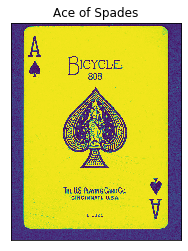

1300 958


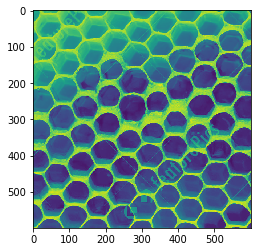

In [30]:
path = 'test_images/ace_spades.jpg'
card = Card(path)
card.display_image()
a = card.load_background_image()
plt.imshow(a)

['Ace of Spades']


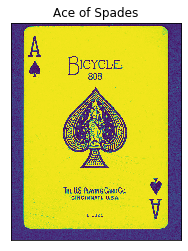

In [6]:
path = 'test_images/ace_spades.jpg'
card = Card(path)
card.display_image()

In [286]:
card.image_resize()

array([[28, 33, 29, ..., 31, 24, 26],
       [31, 30, 29, ..., 31, 29, 28],
       [27, 28, 31, ..., 28, 28, 28],
       ...,
       [35, 35, 32, ..., 42, 39, 39],
       [36, 35, 34, ..., 38, 38, 35],
       [34, 38, 34, ..., 40, 37, 37]], dtype=uint8)

In [287]:
card.preprocess()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

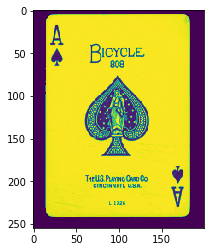

In [288]:
card.reset_altered()

plt.imshow(card.altered)

In [289]:
card.rotate(45)

['Ace of Spades']


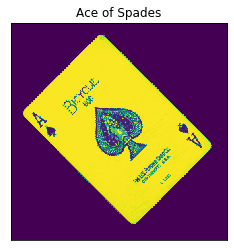

In [290]:
card.display_altered()

In [291]:
card.warp(x = 55, err = True)

[[  0.   0.]
 [  0. 322.]
 [323.   0.]
 [323. 322.]] [[ 13. 171.]
 [  0. 322.]
 [310. 171.]
 [323. 322.]]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

['Ace of Spades']


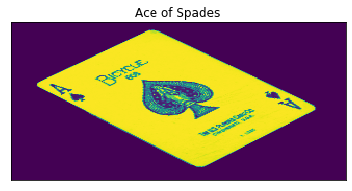

In [292]:
card.display_altered()

In [293]:
card.load_background_image()

array([[121, 125, 126, ..., 108, 212, 229],
       [133, 132, 128, ..., 144, 241, 228],
       [138, 133, 125, ..., 182, 249, 143],
       ...,
       [ 27,  26,  32, ...,  96,  32,  54],
       [ 23,  30,  38, ...,  62,  55,  66],
       [ 39,  24,  27, ...,  91,  75,  62]], dtype=uint8)

### remove the background of the image

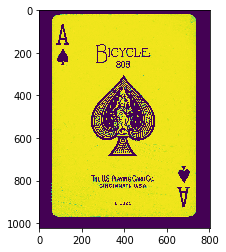

In [294]:
plt.imshow(matrix_image)

In [295]:
path_background = 'images/background/bg1.jpg'

background_image = cv2.imread(path_background, 0)

In [296]:
alt = card.altered

In [297]:
background_image.shape

(533, 800)

In [298]:
alt = card.altered
back = background_image.copy()

bheight = background_image.shape[0]
bwidth = background_image.shape[1]

imheight = alt.shape[0]
imwidth = alt.shape[1]

delta_x = bwidth - imwidth
delta_y = bheight - imheight

for row in range(imheight):
    for col in range(imwidth):
        if alt[row, col] > 0:
            back[delta_y + row, delta_x + col] = alt[row, col]


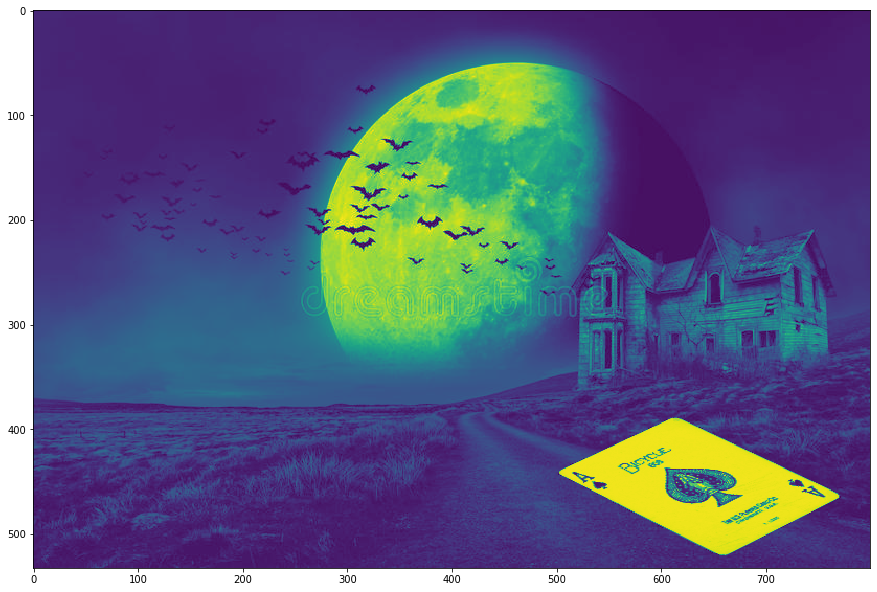

In [299]:
plt.figure(figsize = (15,15))
plt.imshow(back)

In [88]:
width = 200
m_h, m_w = matrix_image.shape



height = int((m_h/m_w) * width)

height, width

(255, 200)

In [89]:
height

255

In [90]:
resized = cv2.resize(matrix_image, (width, height), interpolation = cv2.INTER_AREA)

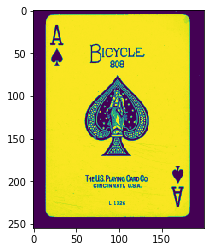

In [91]:
plt.imshow(resized)

In [ ]:
b_h, b_w = background_image.shape()
i_h, i_w = matrix_image.shape()

rows, cols = matrix_image.shape
print(rows ,cols)